<a href="https://colab.research.google.com/github/NicolasPCS/Image-Classification/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tranfer Learning con VGG16 en Keras

## Importando las librerías

In [20]:
!pip install livelossplot

import os
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
from livelossplot.inputs.keras import PlotLossesCallback

from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preparando los datos de entrenamiento y pruebas

In [31]:
# Image generators
## Definimos el batch size
BATCH_SIZE = 32

'''
Se utiliza 'ImageDataGenerator' para aumentar la cantidad de datos de entrenamiento
y preprocesar las imágenes de manera eficiente antes de alimentar el modelo.
Facilica la generación de imágenes de entrenamiento y validación en tiempo real
mientras se entrena el modelo.
'''
train_generator = ImageDataGenerator(rotation_range=90, # random rotation by 90 degrees
                                     brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
                                     width_shift_range=0.5, # shift the width of the image 50%
                                     height_shift_range=0.5,
                                     horizontal_flip=True, # 180 degree flip horizontally
                                     vertical_flip=True, # 180 degree flip vertically
                                     validation_split=0.15, # 15% of the data will be used for validation at end of each epoch
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

# Importando los datos

data_dir = Path('/content/drive/MyDrive/Tesis/New_Images_Dataset')

train_data_dir = data_dir/'training_set'
test_data_dir =data_dir/'validation_set'

class_subset = sorted(os.listdir(data_dir/'training_set'))[:16] # Utilizando las 16 primera clases

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training', # Partición en la cual se utilizará
                                               batch_size=BATCH_SIZE,
                                               shuffle=True, # Baraja los datos aleatoriamente para aumentar la diversidad
                                               seed=42) # Establece una semilla para la aletoriedad, lo que garantiza
                                               # que los datos se barajen de la misma manera en cada ejecución

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 5590 images belonging to 16 classes.
Found 978 images belonging to 16 classes.
Found 2487 images belonging to 16 classes.


## Utilizando las capas preentrenadas para la extracción de características

In [32]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Se compila el modelo VGG16 integrado con las capas preentrenadas

    input_shape: tuple - tamaño de las imágenes de entrada (width, height, channels)
    n_classes: int - número de clases para la capa de salida
    optimizer: string - optimizador instanciado a utilizar para el entrenamiento. Por defecto es 'RMSProp'
    fine_tune: int - El número de capas pre-entrenadas a descongelar.
                Si se establece en 0, todas las capas preentrenadas se congelarán durante el entrenamiento
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.

    '''
    ReLU (Rectified Linear Unit): La función ReLU es una función de activación simple pero efectiva.
    Se define como f(x) = max(0, x), lo que significa que cualquier valor de entrada negativo se
    convierte en cero, y los valores positivos se mantienen sin cambios.
    La función ReLU introduce no linealidad en la red, lo que permite que la red aprenda representaciones
    más complejas de los datos. Además, su derivada es fácil de calcular, lo que facilita el entrenamiento
    mediante retropropagación.

    Softmax: La función softmax se utiliza comúnmente en la capa de salida para problemas de clasificación multiclase.
    Convierte un vector de entradas en una distribución de probabilidad sobre múltiples clases.
    Cada salida representa la probabilidad de pertenencia a una clase.
    '''

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy', # Utilizado en problemas de clasificación multiclase
                  metrics=['accuracy'])

    return model

### Entrenando el modelo sin fine-tuning

In [33]:
'''
Una tasa de aprendizaje más alta permite que la red aprenda más rápido, pero puede hacer que el proceso
de entrenamiento sea inestable o que no converja. Por otro lado, una tasa de aprendizaje más baja puede
hacer que el entrenamiento sea más lento, pero aumenta la estabilidad y la probabilidad de convergencia.
'''

input_shape = (224, 224, 3) # Tamaño de lás imágenes de entrada
optim_1 = RMSprop(learning_rate=0.001)
n_classes=16

n_steps = traingen.samples // BATCH_SIZE # Cantidad de pasos (batches) por epoca durante el entrenamiento
n_val_steps = validgen.samples // BATCH_SIZE # Cantidad de pasos para la validación
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [34]:
plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

'''
early_stop: Este es un callback de EarlyStopping. Su objetivo es monitorear la métrica especificada
(val_loss en este caso) en el conjunto de validación durante el entrenamiento. Si la métrica no
mejora durante un número especificado de épocas (en este caso, 10 épocas), el entrenamiento se detiene
prematuramente. La opción restore_best_weights=True asegura que el modelo se restablezca a los mejores
pesos guardados si se detiene el entrenamiento.

'''

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

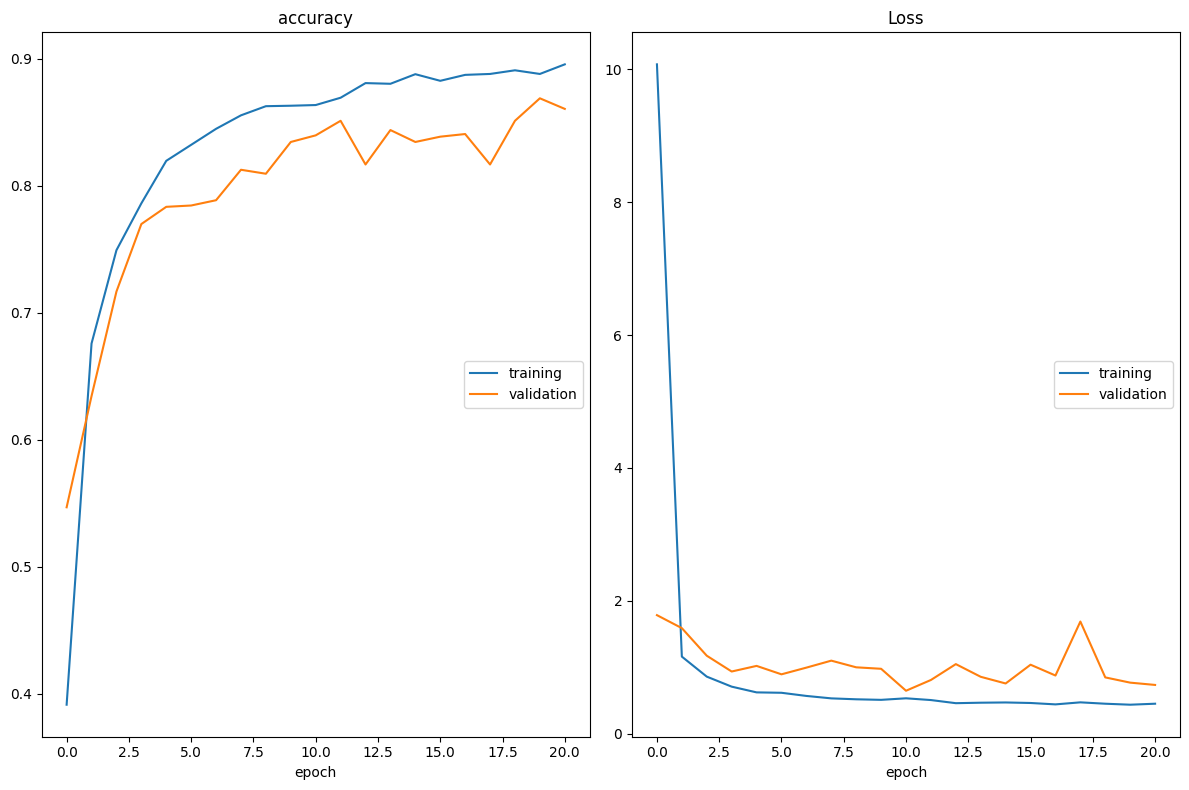

accuracy
	training         	 (min:    0.392, max:    0.895, cur:    0.895)
	validation       	 (min:    0.547, max:    0.869, cur:    0.860)
Loss
	training         	 (min:    0.434, max:   10.075, cur:    0.449)
	validation       	 (min:    0.645, max:    1.783, cur:    0.732)
174/174 [==============================] - 101s 579ms/step - loss: 0.4494 - accuracy: 0.8955 - val_loss: 0.7321 - val_accuracy: 0.8604
CPU times: user 34min 4s, sys: 49.5 s, total: 34min 54s
Wall time: 35min 23s


In [35]:
%%time

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

### Generar predicciones

In [36]:
# Generate predictions
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

2487/2487 [==============================] - 12s 5ms/step


In [37]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 42.78%


### Entrenando el modelo con fine-tuning

In [38]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_2 = RMSprop(learning_rate=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

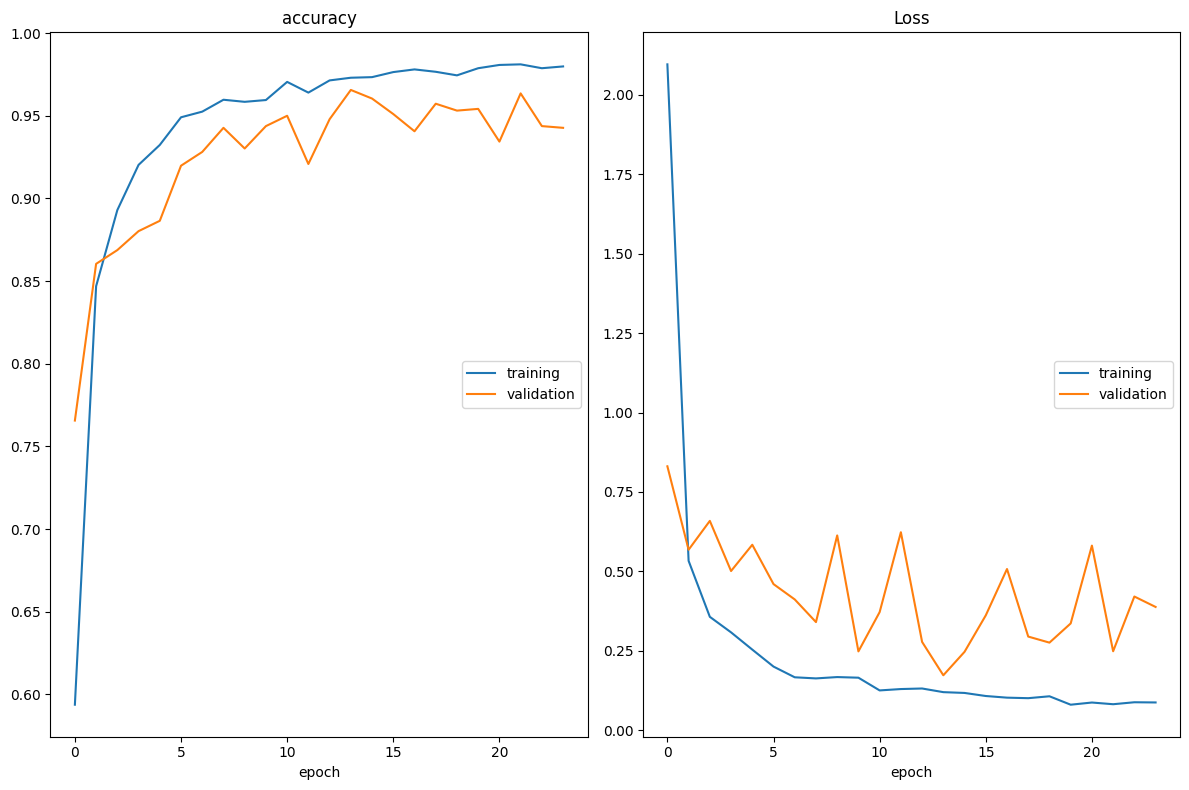

accuracy
	training         	 (min:    0.594, max:    0.981, cur:    0.980)
	validation       	 (min:    0.766, max:    0.966, cur:    0.943)
Loss
	training         	 (min:    0.080, max:    2.096, cur:    0.087)
	validation       	 (min:    0.173, max:    0.831, cur:    0.388)
174/174 [==============================] - 101s 583ms/step - loss: 0.0872 - accuracy: 0.9798 - val_loss: 0.3879 - val_accuracy: 0.9427
CPU times: user 39min 10s, sys: 57.2 s, total: 40min 7s
Wall time: 40min 33s


In [39]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [40]:
# Generate predictions
vgg_model_ft.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

vgg_preds_ft = vgg_model_ft.predict(testgen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

2487/2487 [==============================] - 12s 5ms/step


In [41]:
vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))

VGG16 Model Accuracy with Fine-Tuning: 60.51%
